# CS 109a Crime Final Project
## Group # 37: Krystal Cantos, Isabelle Feldhaus, Chi Gao

## Read in libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import difflib
difflib.get_close_matches
import numpy as np
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import statsmodels.api as sm
import seaborn as sns
import sklearn as sk
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.model_selection import cross_val_score
sns.set_context("poster")
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from statsmodels.api import OLS
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from statsmodels.tools import add_constant
sns.set(style="ticks")
%matplotlib inline

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Uniform Crime Reporting Program FBI Website Scrape 

In [2]:
#UCRP FBI Website Scrape
#programmatically navigate to violent crimes, 
req = requests.get("https://ucr.fbi.gov/ucr-publications")
page = req.text
soup = BeautifulSoup(page, 'html.parser')
year_tables = {}

for year in range(2006, 2017):
    year_url = (soup.find('a', href=True, 
                          text=str(year))['href'].replace('rankingmessage.htm', ''))
    year_req = requests.get(year_url)
    year_page = year_req.text
    year_soup = BeautifulSoup(year_page, 'html.parser')
    vc_url = year_soup.find('a', href=True, text='Violent Crime')['href']

    if vc_url[:4] != 'http':
        year_url = year_url.replace('/index.html', '')
        vc_url = year_url + ('/' if year_url[-1] != '/' else '') + vc_url
        
#and then to murders, 
    vc_req = requests.get(vc_url)
    vc_page = vc_req.text
    vc_soup = BeautifulSoup(vc_page, 'html.parser')
    murder_url = vc_soup.find('a', href=True, text='Murder')['href']
    
    if murder_url[:4] != 'http':
        murder_url = vc_url.replace('/index.html', '') + '/' + murder_url

# and scrape the table corresponding to MSAs   
    murder_req = requests.get(murder_url)
    murder_page = murder_req.text
    murder_soup = BeautifulSoup(murder_page, 'html.parser')
    table_url = murder_soup.find('a', href=True, 
                                 text=re.compile(r"Metropolitan Statistical Areas|Metropolitian Statistical Areas"))['href']
    if table_url[0:4] != 'http':
        if table_url[0:5] == '../..':
            table_url = year_url + (table_url[5:] if year_url[-1] != '/' else table_url[6:])
        else:
            table_url = 'https://ucr.fbi.gov' + table_url
    
    table_req = requests.get(table_url)
    table_page = table_req.text
    table_soup = BeautifulSoup(table_page, 'html.parser')
   
    year_tables[year] = table_soup.find('table', 'data')
    
    
    


In [3]:
#create the FBI dataframe
key = [
       'Population', 'Violent Crime', 'Murder', 
       'Forcible Rape', 'Robbery', 'Aggravated Assault', 
       'Property Crime', 'Burglary', 'Larceny-theft', 'Motor vehicle theft'
      ]

data = []

for year in range(2006, 2017):
    year_table = year_tables[year]
    
    # if you don't want M.D.'s, just make this line
    # for elem in year_table(text=re.compile(r'\bM\.S\.A\.')):
    for elem in year_table(text=re.compile(r'\bM\.S\.A\.')):
        msa_dict = {}
        data_points = []
        msa_dict['M.S.A'] = elem

        for parent in elem.parents:
            if parent.name == 'th':
                msa_id = parent.get('id')
            elif parent.name == 'tr':
                parent_row = parent
                break
        
        for td in parent_row.find_all('td'):
            try: 
                data_points.append(float(td.text.replace(',','')))
            except:
                pass

        if year_table.find('th', text=re.compile(r"Rate per 100,000"), headers=re.compile(r"\b{}\b".format(msa_id))):
            data_row = year_table.find('th', text=re.compile(r"Rate per 100,000"), headers=re.compile(r"\b{}\b".format(msa_id))).parent

            for td in data_row.find_all('td'):
                try:
                    data_points.append(float(td.text.replace(',','')))
                except:
                    pass

            for i in range(len(data_points)):
                msa_dict[key[i]] = data_points[i]
            
            msa_dict['Year'] = year
            data.append(msa_dict)
            
        else:
            print(year)
        

crime_df = pd.DataFrame(data)

2006
2010


## Exploring/Cleaning FBI Crime Data

In [4]:
crime_df.head()

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,M.S.A,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime,Year
0,275.2,940.6,46.1,2366.4,"Abilene, TX M.S.A.",219.9,3.7,162776.0,3526.9,67.0,391.9,2006
1,216.0,1286.4,22.0,2673.9,"Albany, GA M.S.A.",306.4,6.5,168071.0,4266.6,157.7,402.2,2006
2,232.2,569.7,24.3,2034.2,"Albany-Schenectady-Troy, NY M.S.A.",139.3,2.1,851151.0,2743.2,113.3,371.8,2006
3,542.7,1109.3,51.9,2885.3,"Albuquerque, NM M.S.A.",830.3,8.9,808790.0,4824.9,174.3,777.8,2006
4,854.2,1533.7,52.0,3329.1,"Alexandria, LA M.S.A.",383.6,7.1,140250.0,5246.3,154.0,1067.4,2006


In [5]:
print('crime dataset shape:', crime_df.shape)
print(crime_df.dtypes)
crime_df.describe()

crime dataset shape: (3806, 12)
Aggravated Assault     float64
Burglary               float64
Forcible Rape          float64
Larceny-theft          float64
M.S.A                   object
Motor vehicle theft    float64
Murder                 float64
Population             float64
Property Crime         float64
Robbery                float64
Violent Crime          float64
Year                     int64
dtype: object


,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime,Year
count,3805.000000,3780.000000,3806.000000,3620.000000,3620.000000,3806.000000,3.806000e+03,3792.000000,3806.000000,3806.000000,3806.000000
mean,271.551879,688.090053,42.196926,2136.395580,215.395967,5.772596,7.040011e+05,2993.640216,164.561797,374.884262,2011.049396
std,197.339389,339.391973,119.046392,661.464986,150.091405,10.404177,1.585328e+06,1017.924946,470.559228,194.664188,3.150984
min,9.900000,21.300000,0.000000,52.500000,12.900000,0.000000,3.315600e+04,140.600000,0.000000,0.000000,2006.000000
25%,157.000000,445.675000,23.400000,1664.350000,111.400000,2.100000,1.400745e+05,2282.800000,44.800000,241.875000,2008.000000
50%,235.900000,627.550000,32.500000,2086.700000,171.800000,3.900000,2.411045e+05,2923.800000,80.100000,349.500000,2011.000000
75%,336.300000,870.800000,45.375000,2554.025000,279.925000,6.300000,5.537818e+05,3649.000000,126.900000,478.175000,2014.000000
max,2982.900000,2706.700000,4000.800000,4830.700000,1355.000000,190.700000,2.017799e+07,7446.700000,5334.600000,1457.700000,2016.000000


In [6]:
#Get a sense of how many missing values there are in the dataframe.
print('Missing:', crime_df.Murder.isnull().sum(), 
      crime_df['Violent Crime'].isnull().sum(),
      crime_df['Aggravated Assault'].isnull().sum(),
      crime_df['Population'].isnull().sum(),
      crime_df['Property Crime'].isnull().sum(),
      crime_df['Year'].isnull().sum())
#missing 1 aggravated assault, 14 property crime

Missing: 0 0 1 0 14 0


In [7]:
crime_df.groupby('Year').count()

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,M.S.A,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime
Year,,,,,,,,,,,
2006,334,333,334,318,334,318,334,334,333,334,334
2007,338,337,338,320,338,320,338,338,338,338,338
2008,335,333,335,318,335,318,335,335,334,335,335
2009,351,346,352,327,352,327,352,352,348,352,352
2010,341,338,341,325,341,325,341,341,339,341,341
2011,347,347,347,336,347,336,347,347,347,347,347
2012,358,351,358,329,358,329,358,358,353,358,358
2013,353,352,353,343,353,343,353,353,353,353,353
2014,346,346,346,327,346,327,346,346,346,346,346


In [8]:
crime_df.groupby('M.S.A').count()['Year']

M.S.A
Abilene, TX M.S.A.                                     11
Aguadilla-Isabela, Puerto Rico M.S.A.                   5
Aguadilla-Isabela-San Sebastian, Puerto Rico M.S.A.     5
Akron, OH M.S.A.                                       10
Albany, GA M.S.A.                                      10
Albany, OR M.S.A.                                       5
Albany-Schenectady-Troy, NY M.S.A.                     10
Albuquerque, NM M.S.A.                                 11
Alexandria, LA M.S.A.                                  10
Allentown-Bethlehem-Easton, PA-NJ M.S.A.                9
Altoona, PA M.S.A.                                     11
Amarillo, TX M.S.A.                                    11
Ames, IA M.S.A.                                        11
Anchorage, AK M.S.A.                                   11
Anderson, IN M.S.A.                                     3
Anderson, SC M.S.A.                                     6
Ann Arbor, MI M.S.A.                                   11
Anniston

In [9]:
#determine how many years of data each MSA has
print('# MSAs with only 1 year of data:',
      (crime_df.groupby('M.S.A').count()['Year']==1).sum(),
      '\n# MSAs with 2 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==2).sum(),
      '\n# MSAs with 3 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==3).sum(),
      '\n# MSAs with 4 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==4).sum(),
      '\n# MSAs with 5 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==5).sum(),
      '\n# MSAs with 6 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==6).sum(),
      '\n# MSAs with 7 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==7).sum(),
      '\n# MSAs with 8 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==8).sum(),
      '\n# MSAs with 9 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==9).sum(),
      '\n# MSAs with 10 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==10).sum(),
      '\n# MSAs with 11 years of data:',
      (crime_df.groupby('M.S.A').count()['Year']==11).sum())

# MSAs with only 1 year of data: 37 
# MSAs with 2 years of data: 18 
# MSAs with 3 years of data: 22 
# MSAs with 4 years of data: 19 
# MSAs with 5 years of data: 85 
# MSAs with 6 years of data: 48 
# MSAs with 7 years of data: 14 
# MSAs with 8 years of data: 21 
# MSAs with 9 years of data: 21 
# MSAs with 10 years of data: 63 
# MSAs with 11 years of data: 163


In [10]:
#in order to merge crime and census data, need to change 'M.S.A' text in crime dataset to 'Metro Area'
crime_df['M.S.A'] = crime_df['M.S.A'].apply(lambda x: x.replace('M.S.A.', 'Metro Area'))
crime_df.head()

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,M.S.A,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime,Year
0,275.2,940.6,46.1,2366.4,"Abilene, TX Metro Area",219.9,3.7,162776.0,3526.9,67.0,391.9,2006
1,216.0,1286.4,22.0,2673.9,"Albany, GA Metro Area",306.4,6.5,168071.0,4266.6,157.7,402.2,2006
2,232.2,569.7,24.3,2034.2,"Albany-Schenectady-Troy, NY Metro Area",139.3,2.1,851151.0,2743.2,113.3,371.8,2006
3,542.7,1109.3,51.9,2885.3,"Albuquerque, NM Metro Area",830.3,8.9,808790.0,4824.9,174.3,777.8,2006
4,854.2,1533.7,52.0,3329.1,"Alexandria, LA Metro Area",383.6,7.1,140250.0,5246.3,154.0,1067.4,2006


In [11]:
#grouped by MSA
crime_df.groupby('M.S.A').sum()
#511 MSAs in crime df

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime,Year
M.S.A,,,,,,,,,,,
"Abilene, TX Metro Area",2814.9,9452.8,546.7,25474.0,2036.8,45.0,1813498.0,36963.4,929.5,4336.2,22121
"Aguadilla-Isabela, Puerto Rico Metro Area",285.6,1822.7,11.4,2428.7,144.9,38.1,1610426.0,4396.2,219.2,554.1,10070
"Aguadilla-Isabela-San Sebastian, Puerto Rico Metro Area",194.2,1841.2,3.6,1998.5,214.9,26.2,1648574.0,4054.5,192.2,416.0,10041
"Akron, OH Metro Area",1490.8,7293.4,416.3,18741.4,1579.5,44.2,7022432.0,28151.3,1076.3,3027.5,20115
"Albany, GA Metro Area",4076.6,12244.7,272.2,28324.1,2247.7,76.4,1598134.0,42816.1,1462.6,5887.9,20113
"Albany, OR Metro Area",258.6,2609.7,107.2,11883.3,1109.6,5.8,600596.0,15602.5,152.5,524.1,10070
"Albany-Schenectady-Troy, NY Metro Area",1861.6,4644.2,224.7,18926.1,972.3,23.0,8654484.0,24542.5,922.9,3032.3,20106
"Albuquerque, NM Metro Area",6136.7,9870.9,729.9,26159.6,5396.6,118.9,9645825.0,43839.2,6213.9,7390.8,22121
"Alexandria, LA Metro Area",8912.4,11216.5,425.1,27950.5,2569.9,85.5,1530482.0,41737.0,2364.1,7458.8,20113


In [12]:
#create a region variable
region = {'CT': 'New England',
 'ME': 'New England',
 'MA': 'New England',
 'NH': 'New England',
 'RI': 'New England',
 'VT': 'New England',
 'NJ': 'Middle Atlantic',
 'NY': 'Middle Atlantic',
 'PA': 'Middle Atlantic',
 'IL': 'East North Central',
 'IN': 'East North Central',
 'MI': 'East North Central',
 'OH': 'East North Central',
 'WI': 'East North Central',
 'IA': 'West North Central',
 'KS': 'West North Central',
 'MN': 'West North Central',
 'MO': 'West North Central',
 'NE': 'West North Central',
 'ND': 'West North Central',
 'SD': 'West North Central',
 'DE': 'South Atlantic',
 'DC': 'South Atlantic',
 'FL': 'South Atlantic',
 'GA': 'South Atlantic',
 'MD': 'South Atlantic',
 'NC': 'South Atlantic',
 'SC': 'South Atlantic',
 'VA': 'South Atlantic',
 'WV': 'South Atlantic',
 'AL': 'East South Central',
 'KY': 'East South Central',
 'MS': 'East South Central',
 'TN': 'East South Central',
 'AR': 'West South Central',
 'LA': 'West South Central',
 'OK': 'West South Central',
 'TX': 'West South Central',
 'AZ': 'Mountain',
 'CO': 'Mountain',
 'ID': 'Mountain',
 'MT': 'Mountain',
 'NV': 'Mountain',
 'NM': 'Mountain',
 'UT': 'Mountain',
 'WY': 'Mountain',
 'AK': 'Pacific',
 'CA': 'Pacific',
 'HI': 'Pacific',
 'OR': 'Pacific',
 'WA': 'Pacific', 
}

def assign_region(msa):
    state = msa.split(', ')[1][:2]
    try:
        return region[state]
    
    except:
        return "Puerto Rico"

crime_df['Region'] = crime_df['M.S.A'].apply(assign_region)

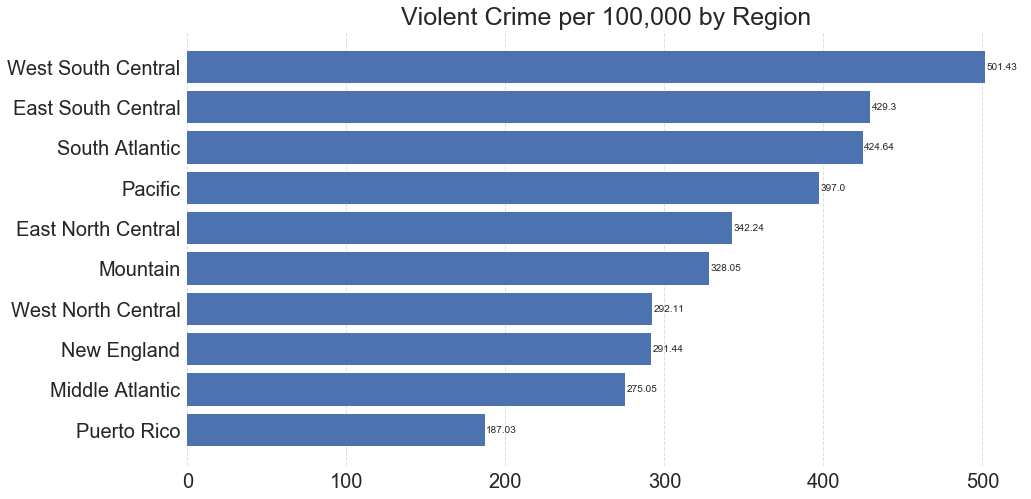

In [13]:
av_vc = crime_df.groupby('Region').mean()['Violent Crime']
plt.figure(figsize=(15, 8))
ax = plt.gca()
av_vc2 = av_vc.sort_values()
msa = av_vc2.index
violence=np.empty(shape=(10,))
violence1 = av_vc2.values
np.around(violence1, decimals=2, out=violence)
nums = np.arange(len(av_vc2))
plt.barh(nums, violence)
for p, c, ch in zip(nums, msa, violence):
    plt.annotate(str(ch), xy=(ch + 1, p), va='center')
ticks = plt.yticks(nums, msa, fontsize=20)
xt = plt.xticks(fontsize=20)[0]
plt.grid(axis = 'x', color ='grey', linestyle='--', alpha=.25)
ax.tick_params(axis='both', which='both',length=0)
plt.title('Violent Crime per 100,000 by Region', size=25)
sns.despine(left=True, bottom=True)

plt.savefig('crime_VCbyRegion.png', format='png')

In [14]:
#save crime dataframe to csv
crime_df.to_csv(path_or_buf='/Users/krystalcantos/Dropbox/CS109FinalProject/crime_df.csv')

In [15]:
#read in crime data
#crime_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/crime_df.csv', 
#                     encoding = "ISO-8859-1", index_col=0)

In [16]:
#read in census data
census_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Age_Sex_200616.csv',
                      encoding = "ISO-8859-1")

In [17]:
print(census_df.shape)
census_df.head()

(4147, 9)


,Id,Id2,M.S.A,Total_Population_Size,Total_Median_Age,Male_Median_Age,Female_Median_Age,Sex_ratio(males per 100 females),Year
0,310M300US10180,10180,"Abilene, TX Metro Area",170860,34.4,33.5,35.7,104.9,2016
1,310M300US10420,10420,"Akron, OH Metro Area",702221,40.2,38.8,41.5,94.5,2016
2,310M300US10500,10500,"Albany, GA Metro Area",152506,36.4,35.5,37.0,89.6,2016
3,310M300US10540,10540,"Albany, OR Metro Area",122849,39.4,37.5,40.8,99.2,2016
4,310M300US10580,10580,"Albany-Schenectady-Troy, NY Metro Area",881839,39.8,38.5,41.2,96.2,2016


In [18]:
#get closest text match in MSA from crime dataframe to MSA in census dataframe
#census_df['M.S.A'] = census_df['M.S.A'].apply(lambda x: difflib.get_close_matches(x, crime_df['M.S.A'])[0])

In [19]:
#merge crime and census dataframes based on MSA and year
result = pd.merge(crime_df, census_df, left_on=('M.S.A','Year'), right_on=('M.S.A','Year'), how='left')
result.shape

(3806, 20)

In [20]:
#check missingness
print('Missing:', result['Violent Crime'].isnull().sum(),
      result['Aggravated Assault'].isnull().sum(),
      result['Population'].isnull().sum(),
      result['Property Crime'].isnull().sum(),
      result['Year'].isnull().sum(),
      result['Region'].isnull().sum(),
      result['Total_Population_Size'].isnull().sum()
     )

Missing: 0 1 0 14 0 0 232


In [21]:
#read in census education, poverty data
pov_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Poverty Level.csv',
                      encoding = "ISO-8859-1")
ed_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Education.csv',
                      encoding = "ISO-8859-1")

In [22]:
print(pov_df.shape)
ed_df.shape

(4154, 5)


(4154, 5)

In [23]:
census1 = pd.merge(pov_df, ed_df, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census1.shape

(4154, 6)

In [24]:
#read in census race, marital status, employment, housing, income inequality data
race_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Race.csv',
                      encoding = "ISO-8859-1")
mars_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Marital_status.csv',
                      encoding = "ISO-8859-1", na_values='N')
emp_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Employment_rate.csv',
                      encoding = "ISO-8859-1")
house_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/Housing.csv',
                      encoding = "ISO-8859-1", na_values='N')
income_df=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/Census_Data/incomeineq.csv',
                      encoding = "ISO-8859-1", na_values='#VALUE!')

In [25]:
#missing several marital status and income observations
print(mars_df.Now_married.isnull().sum())
income_df['Ratio less than 10k to 65K+ income'].isnull().sum()

586


238

In [26]:
#first we impute the missing with the mean for that M.S.A over the years for which this data is available
marital = mars_df.copy()
marital['Now_married'] = marital['Now_married'].fillna(marital['Now_married'].groupby(marital['M.S.A']).transform('mean'))
income = income_df.copy()
income['Ratio less than 10k to 65K+ income'] = income['Ratio less than 10k to 65K+ income'].fillna(income['Ratio less than 10k to 65K+ income'].groupby(income['M.S.A']).transform('mean'))


In [27]:
#this now only leaves us with 109 observations missing marital status, 8 missing income
print(marital.Now_married.isnull().sum())
income['Ratio less than 10k to 65K+ income'].isnull().sum()

109


8

In [28]:
#check if imputed mean % married is the same as actual mean of % married for a given MSA (it worked!)
print(marital[:10])
mars_df.groupby('M.S.A').mean()[:9]

               Id    Id2                                         M.S.A  Year  \
0  310M300US10180  10180                        Abilene, TX Metro Area  2016   
1  310M300US10380  10380              Aguadilla-Isabela, PR Metro Area  2016   
2  310M300US10420  10420                          Akron, OH Metro Area  2016   
3  310M300US10500  10500                         Albany, GA Metro Area  2016   
4  310M300US10540  10540                         Albany, OR Metro Area  2016   
5  310M300US10580  10580        Albany-Schenectady-Troy, NY Metro Area  2016   
6  310M300US10740  10740                    Albuquerque, NM Metro Area  2016   
7  310M300US10780  10780                     Alexandria, LA Metro Area  2016   
8  310M300US10900  10900  Allentown-Bethlehem-Easton, PA-NJ Metro Area  2016   
9  310M300US11020  11020                        Altoona, PA Metro Area  2016   

   Now_married  Widowed  Divorced  Separated  Never married  
0         46.8      5.5      10.9        2.5           34

,Id2,Year,Now_married,Widowed,Divorced,Separated,Never married
M.S.A,,,,,,,
"Abilene, TX Metro Area",10180.0,2011.0,48.645455,6.600000,11.772727,2.409091,30.527273
"Aguadilla-Isabela, PR Metro Area",10380.0,2014.5,40.825000,7.450000,12.825000,3.175000,35.750000
"Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",10380.0,2009.0,42.757143,7.028571,12.028571,3.242857,34.928571
"Akron, OH Metro Area",10420.0,2011.0,47.827273,6.363636,11.781818,1.500000,32.500000
"Albany, GA Metro Area",10500.0,2011.0,41.154545,7.309091,11.818182,3.727273,36.000000
"Albany, OR Metro Area",10540.0,2014.5,NaN,NaN,NaN,NaN,NaN
"Albany-Schenectady-Troy, NY Metro Area",10580.0,2011.0,46.445455,6.345455,9.418182,2.209091,35.581818
"Albuquerque, NM Metro Area",10740.0,2011.0,45.963636,5.481818,13.236364,1.736364,33.590909
"Alexandria, LA Metro Area",10780.0,2011.0,45.700000,7.300000,12.962500,3.262500,30.750000


In [29]:
# set the remaining observations missing 'now married' 
#(those MSAs where no data from other years is available for % now married)
# to the mean for that MSA's region
marital['Region'] = marital['M.S.A'].apply(assign_region)
income['Region'] = income['M.S.A'].apply(assign_region)

In [30]:
marital['Now_married'] = marital['Now_married'].fillna(marital['Now_married'].groupby(marital['Region']).transform('mean'))
print(marital.Now_married.isnull().sum())
marital.drop(['Widowed','Divorced',
             'Separated', 'Never married'], axis=1, inplace=True)

0


In [31]:
income['Ratio less than 10k to 65K+ income'] = income['Ratio less than 10k to 65K+ income'].fillna(income['Ratio less than 10k to 65K+ income'].groupby(income['Region']).transform('mean'))
print(income['Ratio less than 10k to 65K+ income'].isnull().sum())
income.drop(['Region'], axis=1, inplace=True)

0


In [32]:
#merge all of the census data
census2 = pd.merge(race_df, marital, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census2.shape

(4118, 19)

In [33]:
census3 = pd.merge(census2, emp_df, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census3.shape

(4118, 21)

In [34]:
census4 = pd.merge(census3, income, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census4.shape

(4118, 22)

In [35]:
census5 = pd.merge(census4, house_df, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census5.shape

(4118, 26)

In [36]:
census = pd.merge(census5, census1, 
                  left_on=('Id','Id2','M.S.A','Year'), 
                  right_on=('Id','Id2','M.S.A','Year'), how='left')
census.shape

(4118, 28)

In [37]:
#merge crime and census dataframes based on MSA and year (include Region to keep as 1 variable)
final = pd.merge(result, census, left_on=('Id','Id2','M.S.A','Year', 'Region'),
                 right_on=('Id','Id2','M.S.A','Year','Region'), how='left')
final.shape

(3806, 43)

In [38]:
# Dropping rows with NaN values -- this means we're getting rid of MSAs 
#for which there was no match on Census-Crime data, 
# we'll check the final # of MSAs to see if we've significantly decreased # of MSAs
final = final.dropna()
final.shape

(3371, 43)

In [39]:
final.groupby('M.S.A').mean()
# 468 MSAs after merge of crime and all census dataframes 
# (down from 511 in crime only)  This is not bad -- Census had fewer MSAs-- 
# we've also lost the Puerto Rico MSAs but we can simply exclude from this analysis,
# since PR may be very different anyway

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,Motor vehicle theft,Murder,Population,Property Crime,Robbery,Violent Crime,...,Now_married,Employment/Population Ratio,Unemployment rate,Ratio less than 10k to 65K+ income,Occupied housing units; Estimate; Occupied housing units,Ratio Owned to Rented homes,Occupied housing units; Estimate; HOUSEHOLD SIZE - 1-person household,Occupied housing units; Estimate; HOUSEHOLD SIZE - 4-or-more-person household,Below_poverty_level,HS_Grad_or_Higher
M.S.A,,,,,,,,,,,,,,,,,,,,,
"Abilene, TX Metro Area",255.900000,859.345455,49.700000,2315.818182,185.163636,4.090909,1.648635e+05,3360.309091,84.500000,394.200000,...,48.645455,54.190909,5.354545,2.684964,5.969145e+04,1.769091,28.281818,20.018182,16.481818,84.236364
"Akron, OH Metro Area",149.355556,796.511111,41.333333,2082.377778,175.500000,4.377778,7.017439e+05,3054.377778,110.766667,305.822222,...,47.688889,59.788889,8.833333,1.589302,2.811917e+05,2.080000,30.666667,19.477778,14.600000,90.977778
"Albany, GA Metro Area",407.660000,1224.470000,27.220000,2832.410000,224.770000,7.640000,1.598134e+05,4281.610000,146.260000,588.790000,...,41.060000,50.590000,13.310000,2.942734,5.875610e+04,1.279000,29.090000,20.950000,25.030000,79.570000
"Albany, OR Metro Area",49.525000,503.850000,21.550000,2377.975000,233.050000,1.450000,1.204088e+05,3114.875000,29.300000,101.825000,...,49.026279,51.925000,9.650000,2.003865,4.569450e+04,1.782500,25.800000,22.650000,17.275000,90.400000
"Albany-Schenectady-Troy, NY Metro Area",186.160000,464.420000,22.470000,1892.610000,97.230000,2.300000,8.654484e+05,2454.250000,92.290000,303.230000,...,46.580000,61.510000,6.550000,1.156623,3.424736e+05,1.886000,31.180000,18.300000,10.840000,91.540000
"Albuquerque, NM Metro Area",519.366667,1011.811111,53.922222,2906.622222,599.622222,6.700000,8.798309e+05,4518.033333,168.655556,748.611111,...,45.911111,58.044444,7.655556,1.457353,3.377917e+05,2.031111,29.911111,21.177778,17.455556,86.588889
"Alexandria, LA Metro Area",658.833333,1246.277778,34.722222,3105.611111,285.544444,6.211111,1.527848e+05,4637.444444,128.344444,828.111111,...,45.322222,51.611111,7.833333,2.584924,5.504000e+04,1.893333,29.577778,20.766667,19.588889,82.033333
"Allentown-Bethlehem-Easton, PA-NJ Metro Area",112.712500,417.950000,18.750000,1751.725000,118.087500,3.225000,8.212371e+05,2287.725000,86.812500,221.500000,...,51.250000,59.525000,8.287500,1.330248,3.115666e+05,2.503750,26.025000,23.162500,10.600000,88.975000
"Altoona, PA Metro Area",173.800000,386.770000,33.680000,1404.230000,74.150000,1.830000,1.260770e+05,1865.140000,49.660000,258.960000,...,50.412500,55.930000,6.750000,3.012932,5.124880e+04,2.552000,29.760000,19.010000,13.610000,90.800000


In [40]:
# final.dtypes

In [41]:
#export combined dataframe to csv
final.to_csv(path_or_buf='/Users/krystalcantos/Dropbox/CS109FinalProject/crimecensusdf.csv')

In [42]:
final.head()

,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,M.S.A,Motor vehicle theft,Murder,Population,Property Crime,Robbery,...,Now_married,Employment/Population Ratio,Unemployment rate,Ratio less than 10k to 65K+ income,Occupied housing units; Estimate; Occupied housing units,Ratio Owned to Rented homes,Occupied housing units; Estimate; HOUSEHOLD SIZE - 1-person household,Occupied housing units; Estimate; HOUSEHOLD SIZE - 4-or-more-person household,Below_poverty_level,HS_Grad_or_Higher
0,275.2,940.6,46.1,2366.4,"Abilene, TX Metro Area",219.9,3.7,162776.0,3526.9,67.0,...,50.9,56.5,6.6,3.618689,59850.0,1.97,28.4,19.9,15.8,79.9
1,216.0,1286.4,22.0,2673.9,"Albany, GA Metro Area",306.4,6.5,168071.0,4266.6,157.7,...,46.1,54.1,10.0,3.653333,61158.0,1.31,25.4,23.9,22.8,79.3
2,232.2,569.7,24.3,2034.2,"Albany-Schenectady-Troy, NY Metro Area",139.3,2.1,851151.0,2743.2,113.3,...,48.1,62.7,5.4,1.621260,337905.0,1.89,30.2,19.9,9.8,89.6
3,542.7,1109.3,51.9,2885.3,"Albuquerque, NM Metro Area",830.3,8.9,808790.0,4824.9,174.3,...,47.2,62.2,5.9,1.994935,318482.0,2.19,30.9,21.0,14.9,83.9
4,854.2,1533.7,52.0,3329.1,"Alexandria, LA Metro Area",383.6,7.1,140250.0,5246.3,154.0,...,46.3,56.3,6.5,3.573580,55546.0,2.10,28.3,19.5,20.2,79.1


## Merge across years to create aggregate model

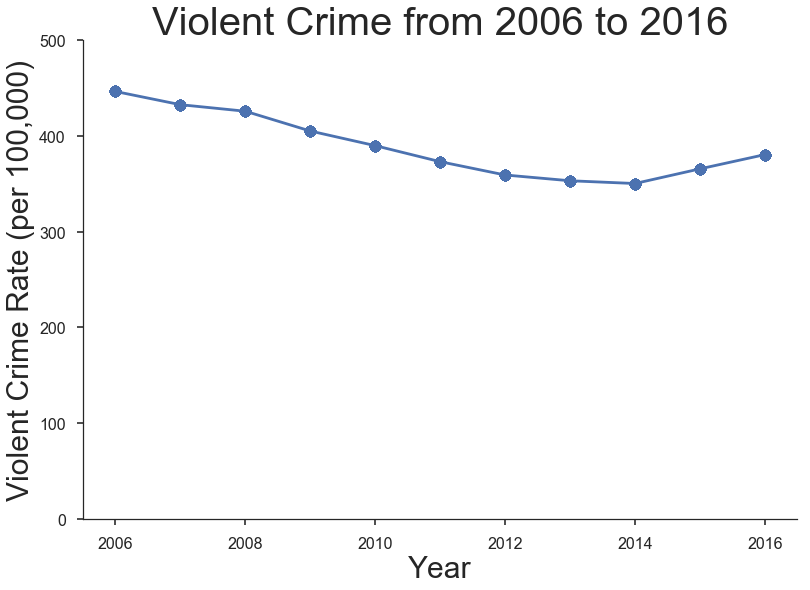

In [43]:
#examine trend in violent crime by year
sns.set_context("poster")
final['meanVC'] = final['Violent Crime'].groupby(final['Year']).transform('mean')
plt.plot(final['Year'], final['meanVC'], 'o-')
plt.ylabel('Violent Crime Rate (per 100,000)', fontsize=30)
plt.ylim(0,500)
plt.xlabel('Year', fontsize=30)
plt.title('Violent Crime from 2006 to 2016', fontsize=40)
sns.despine()
plt.savefig('ViolentCrimeoverTime.png', format='png')

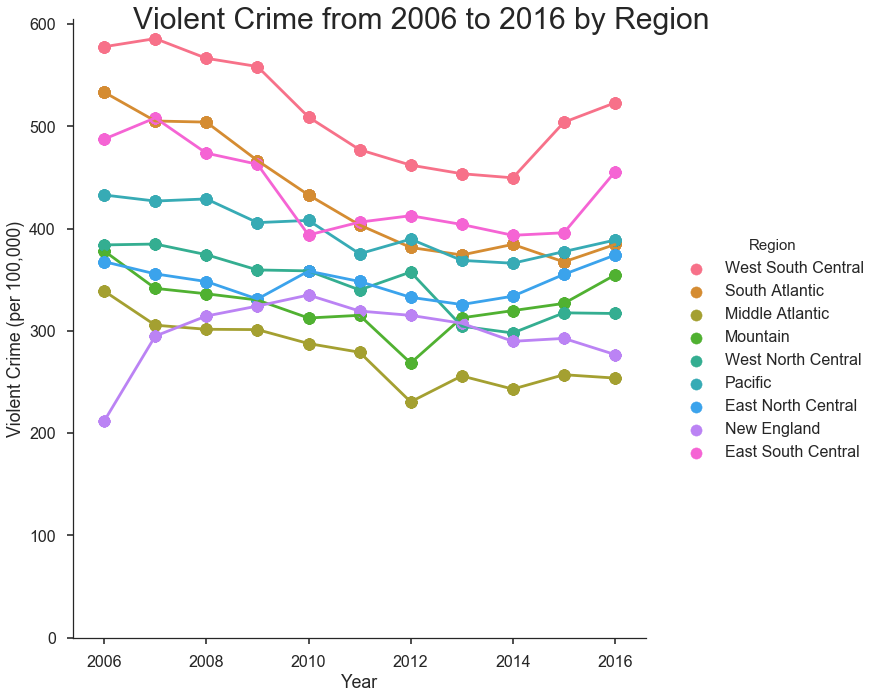

In [44]:
#examine trend by year across Regions
final['meanVC2'] = (final.groupby(['Year', 'Region']))['Violent Crime'].transform('mean')
sns.set(font_scale=2)
sns.set(style="ticks")
sns.set_context("poster")
g = sns.FacetGrid(final, hue='Region', size=10, margin_titles=True)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Violent Crime from 2006 to 2016 by Region', fontsize=30)
g.map(plt.scatter, "Year", "meanVC2")
g.map(plt.plot, "Year", "meanVC2") .add_legend() .set_axis_labels("Year", "Violent Crime (per 100,000)")
g.set(ylim=(0, None))
plt.savefig('ViolentCrimeoverTimebyRegion.png', format='png')

In [45]:
aggregate = final.groupby('M.S.A').mean()
aggregate.reset_index(inplace=True)

In [46]:
aggregate['Region'] = aggregate['M.S.A'].apply(assign_region)
aggregate.head()

,M.S.A,Aggravated Assault,Burglary,Forcible Rape,Larceny-theft,Motor vehicle theft,Murder,Population,Property Crime,Robbery,...,Ratio less than 10k to 65K+ income,Occupied housing units; Estimate; Occupied housing units,Ratio Owned to Rented homes,Occupied housing units; Estimate; HOUSEHOLD SIZE - 1-person household,Occupied housing units; Estimate; HOUSEHOLD SIZE - 4-or-more-person household,Below_poverty_level,HS_Grad_or_Higher,meanVC,meanVC2,Region
0,"Abilene, TX Metro Area",255.900000,859.345455,49.700000,2315.818182,185.163636,4.090909,164863.454545,3360.309091,84.500000,...,2.684964,59691.454545,1.769091,28.281818,20.018182,16.481818,84.236364,389.210665,515.213064,West South Central
1,"Akron, OH Metro Area",149.355556,796.511111,41.333333,2082.377778,175.500000,4.377778,701743.888889,3054.377778,110.766667,...,1.589302,281191.666667,2.080000,30.666667,19.477778,14.600000,90.977778,387.181977,347.733269,East North Central
2,"Albany, GA Metro Area",407.660000,1224.470000,27.220000,2832.410000,224.770000,7.640000,159813.400000,4281.610000,146.260000,...,2.942734,58756.100000,1.279000,29.090000,20.950000,25.030000,79.570000,385.552786,423.374533,South Atlantic
3,"Albany, OR Metro Area",49.525000,503.850000,21.550000,2377.975000,233.050000,1.450000,120408.750000,3114.875000,29.300000,...,2.003865,45694.500000,1.782500,25.800000,22.650000,17.275000,90.400000,362.327983,375.327678,Pacific
4,"Albany-Schenectady-Troy, NY Metro Area",186.160000,464.420000,22.470000,1892.610000,97.230000,2.300000,865448.400000,2454.250000,92.290000,...,1.156623,342473.600000,1.886000,31.180000,18.300000,10.840000,91.540000,391.578267,279.714620,Middle Atlantic


In [47]:
#export aggregate (means across years) dataframe to csv
aggregate.to_csv(path_or_buf='/Users/krystalcantos/Dropbox/CS109FinalProject/aggregate_df.csv')

In [48]:
#aggregate=pd.read_csv('/Users/krystalcantos/Dropbox/CS109FinalProject/aggregate_df.csv')
#aggregate.head()

In [49]:
#determine the differences between Total population size provided by FBI and Census Bureau
aggregate['PopDiff'] = aggregate['Population']-aggregate['Total_Population_Size']
np.mean(aggregate['Population']-aggregate['Total_Population_Size'])

-1223.2781638114932

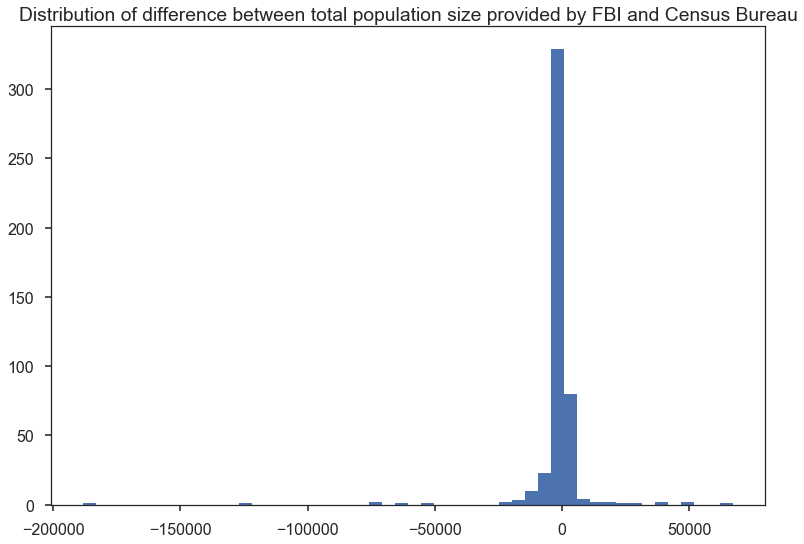

In [50]:
plt.hist(aggregate['PopDiff'], bins=50)
plt.title('Distribution of difference between total population size provided by FBI and Census Bureau')
plt.show()

In [51]:
# we'll take the average of the FBI and Census population sizes to use as the population size predictor variable
aggregate['PopSize'] = (aggregate['Population']+aggregate['Total_Population_Size'])/2

In [53]:
aggregate.drop(['meanVC', 'meanVC2',
                'White alone', 'Black or African American alone',
               'American Indian and Alaska Native alone', 'Asian alone',
               'Native Hawaiian and Other Pacific Islander alone',
               'Some other race alone','PopDiff', 'Total_Population_Size', 
                'Population', 'Total'], axis=1, inplace=True)

In [54]:
aggregate.rename(columns={'Occupied housing units; Estimate; HOUSEHOLD SIZE - 1-person household': 
                           '% 1-person households',
                           'Occupied housing units; Estimate; HOUSEHOLD SIZE - 4-or-more-person household': 
                           '% 4 or more person households',
                           'Occupied housing units; Estimate; Occupied housing units':
                            'Occupied housing units'}, inplace=True)

In [55]:
aggregate.dtypes

M.S.A                                                 object
Aggravated Assault                                   float64
Burglary                                             float64
Forcible Rape                                        float64
Larceny-theft                                        float64
Motor vehicle theft                                  float64
Murder                                               float64
Property Crime                                       float64
Robbery                                              float64
Violent Crime                                        float64
Year                                                 float64
Total_Median_Age                                     float64
Male_Median_Age                                      float64
Female_Median_Age                                    float64
Sex_ratio(males per 100 females)                     float64
%White alone                                         float64
%Black or African Americ

## Split out Test Set for Later

In [56]:
np.random.seed(9001)
msk = np.random.rand(len(aggregate)) < 0.75
train = aggregate[msk]
test = aggregate[~msk]
print(train.shape)
print(test.shape)

(339, 33)
(129, 33)


## EDA in Training Set

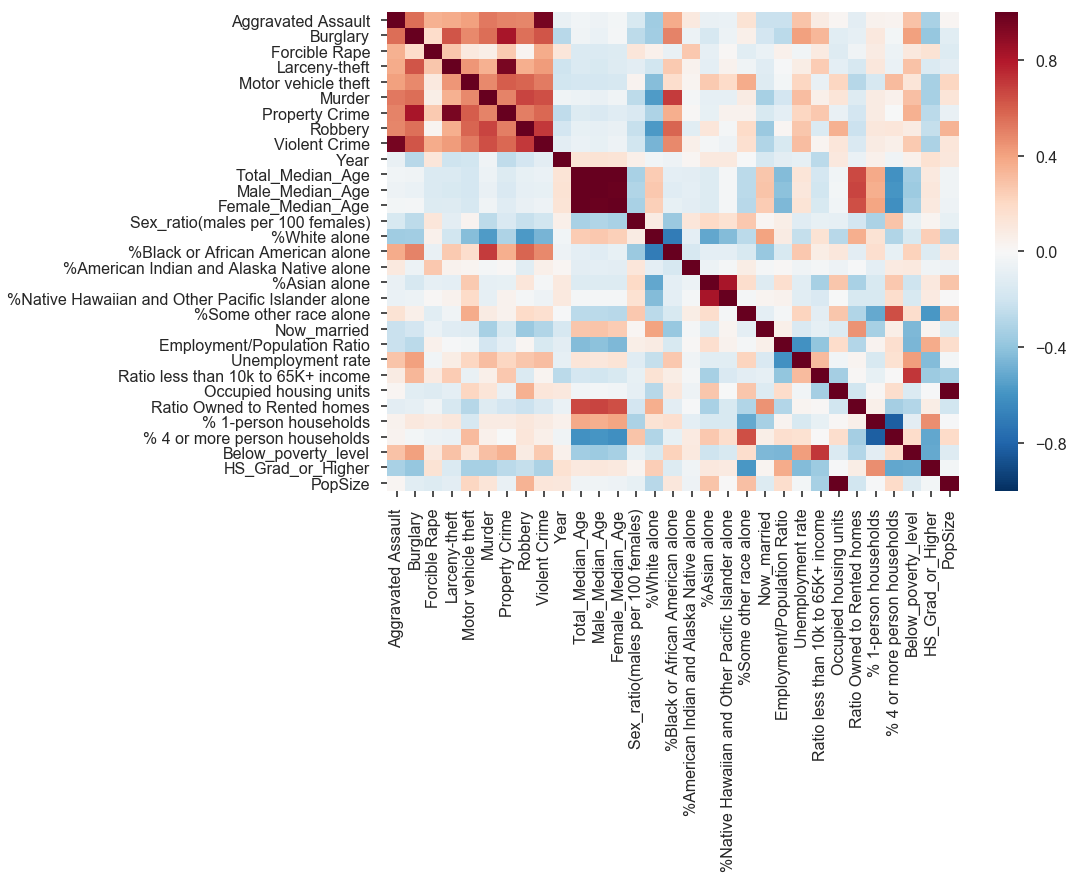

In [57]:
# see correlation between all continuous variables (so categorical Region predictor is excluded)
sns.set_context("poster")
sns.heatmap(train.corr())
plt.show()

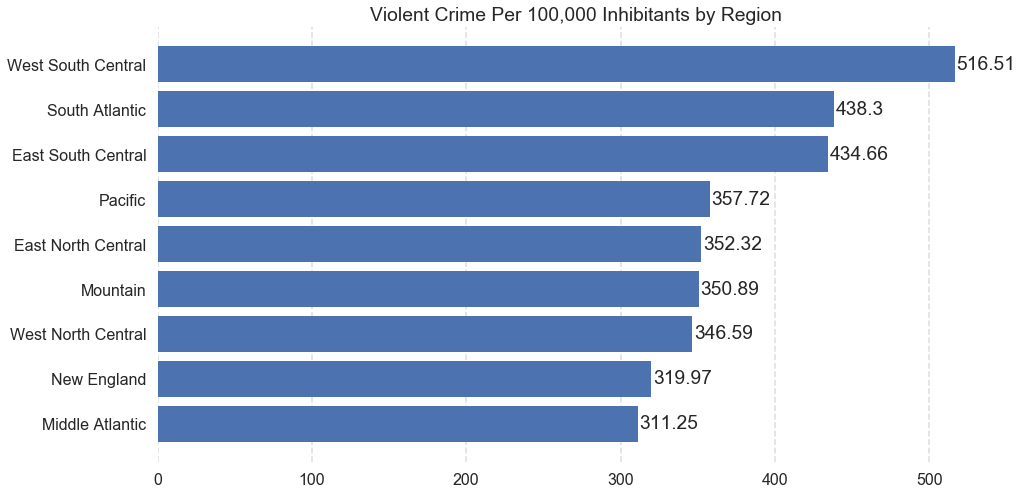

In [58]:
#look at violent crime by region in trainign set
av_vc = train.groupby('Region').mean()['Violent Crime']
plt.figure(figsize=(15, 8))
ax = plt.gca()
av_vc2 = av_vc.sort_values()
msa = av_vc2.index
violence1 = av_vc2.values
violence=np.empty(shape=(9,))
np.around(violence1, decimals=2, out=violence)
nums = np.arange(len(av_vc2))
plt.barh(nums, violence)
for p, c, ch in zip(nums, msa, violence):
    plt.annotate(str(ch), xy=(ch + 1, p), va='center')
ticks = plt.yticks(nums, msa)
xt = plt.xticks()[0]
plt.grid(axis = 'x', color ='grey', linestyle='--', alpha=.25)
ax.tick_params(axis='both', which='both',length=0)
plt.title('Violent Crime Per 100,000 Inhibitants by Region')
sns.despine(left=True, bottom=True)

In [59]:
#scatter plots function
def splt(x, y, xlab, ylab, ttl, ax):
    ax.plot(x, y, marker='o', markersize=20, linestyle='None', alpha=.5)
    ax.set_ylabel(ylab, fontsize=50)
    ax.set_xlabel(xlab, fontsize=50)
    ax.set_title(ttl, fontsize=60)
    ax.tick_params(labelsize=40)
    # calc the trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x ,p(x),"r--", linewidth=10)

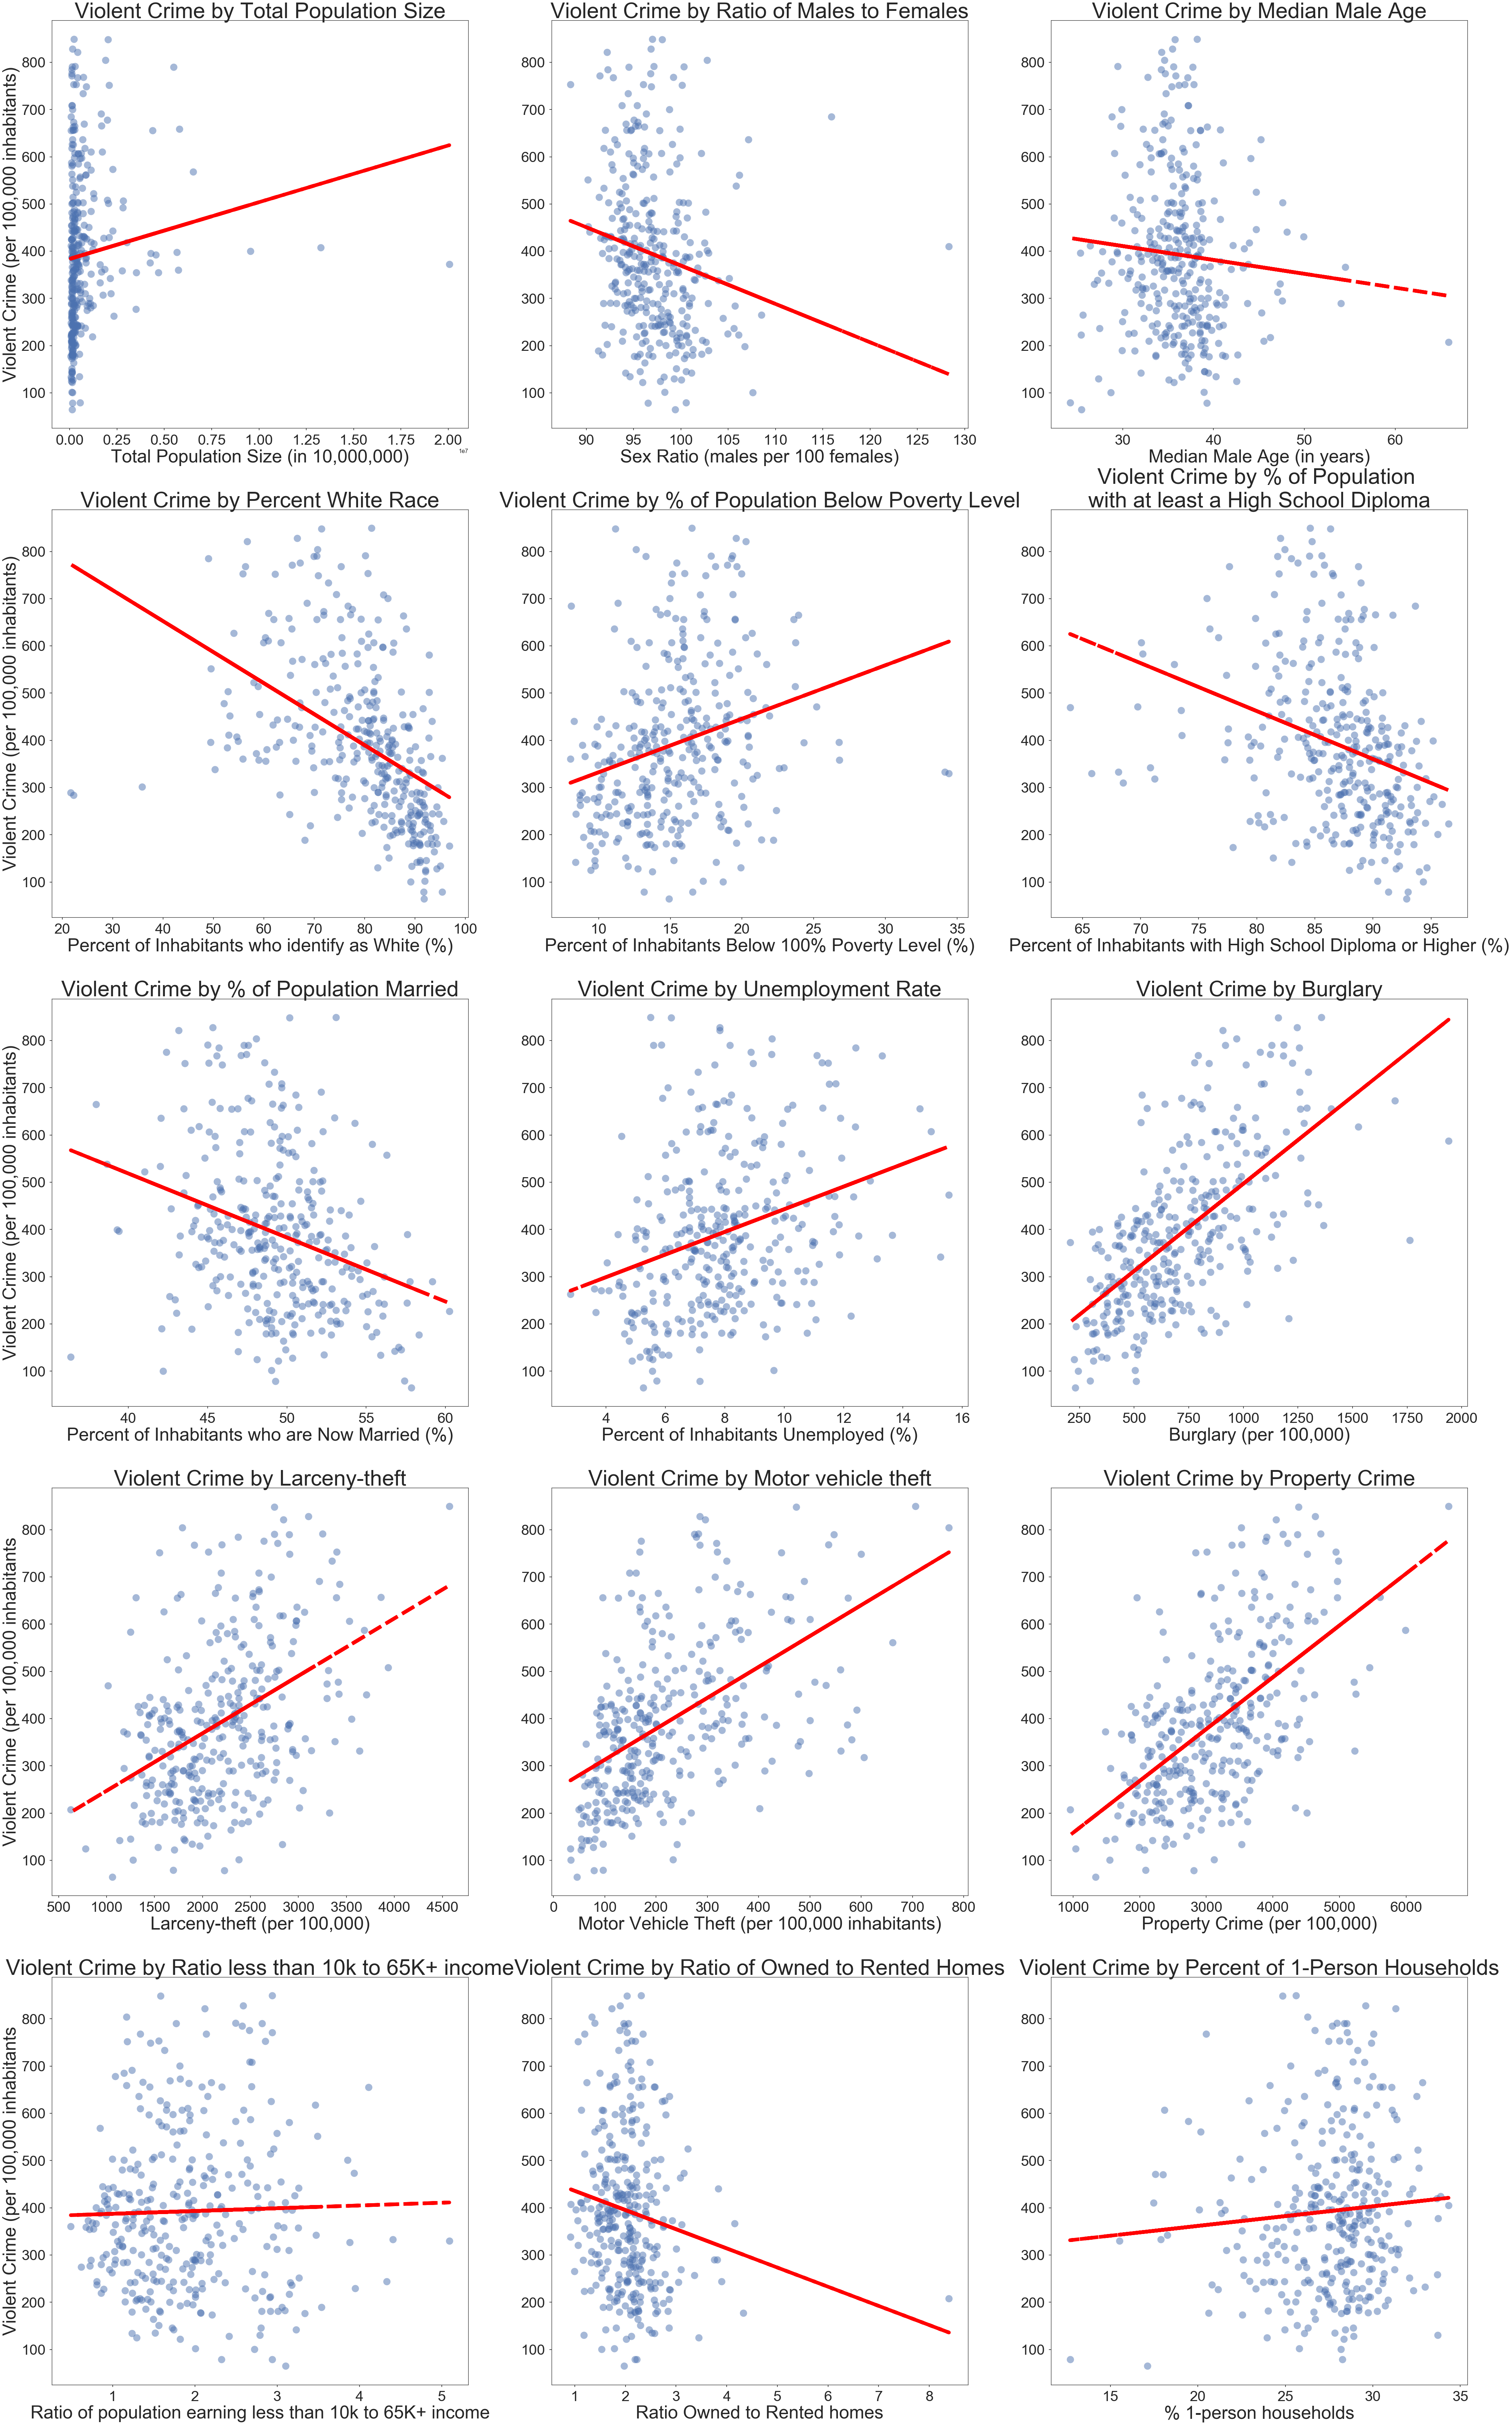

In [60]:
#scatter plots of important continous predictors with Violent crime
fig = plt.figure(figsize=(70,120))
y=train['Violent Crime']

ax1 = fig.add_subplot(531)
splt(train['PopSize'], y, 'Total Population Size (in 10,000,000)', 
     'Violent Crime (per 100,000 inhabitants)', 'Violent Crime by Total Population Size', ax1)
ax2 = fig.add_subplot(532)
splt(train['Sex_ratio(males per 100 females)'], y, 
     'Sex Ratio (males per 100 females)', 
     '', 'Violent Crime by Ratio of Males to Females', ax2)
ax3 = fig.add_subplot(533)
splt(train['Male_Median_Age'], y, 'Median Male Age (in years)', 
     '', 'Violent Crime by Median Male Age', ax3)
ax4 = fig.add_subplot(534)
splt(train['%White alone'], y, 'Percent of Inhabitants who identify as White (%)', 
     'Violent Crime (per 100,000 inhabitants)', 'Violent Crime by Percent White Race', ax4)
ax5 = fig.add_subplot(535)
splt(train['Below_poverty_level'], y, 'Percent of Inhabitants Below 100% Poverty Level (%)', 
     '', 'Violent Crime by % of Population Below Poverty Level', ax5)
ax6 = fig.add_subplot(536)
splt(train['HS_Grad_or_Higher'], y, 'Percent of Inhabitants with High School Diploma or Higher (%)', 
     '', 'Violent Crime by % of Population \nwith at least a High School Diploma', ax6)
ax7 = fig.add_subplot(537)
splt(train['Now_married'], y, 'Percent of Inhabitants who are Now Married (%)', 
     'Violent Crime (per 100,000 inhabitants)', 'Violent Crime by % of Population Married', ax7)
ax8 = fig.add_subplot(538)
splt(train['Unemployment rate'], y, 'Percent of Inhabitants Unemployed (%)', 
     '', 'Violent Crime by Unemployment Rate', ax8)
ax9 = fig.add_subplot(539)
splt(train['Burglary'], y, 
     'Burglary (per 100,000)', '', 
     'Violent Crime by Burglary', ax9)
ax10 = fig.add_subplot(5,3,10)
splt(train['Larceny-theft'], y, 
     'Larceny-theft (per 100,000)', 'Violent Crime (per 100,000 inhabitants', 
     'Violent Crime by Larceny-theft', ax10)
ax11 = fig.add_subplot(5,3,11)
splt(train['Motor vehicle theft'], y, 
     'Motor Vehicle Theft (per 100,000 inhabitants)', '', 
     'Violent Crime by Motor vehicle theft', ax11)
ax12 = fig.add_subplot(5,3,12)
splt(train['Property Crime'], y, 'Property Crime (per 100,000)', 
     '', 'Violent Crime by Property Crime', ax12)
ax13 = fig.add_subplot(5,3,13)
splt(train['Ratio less than 10k to 65K+ income'], y, 'Ratio of population earning less than 10k to 65K+ income', 
     'Violent Crime (per 100,000 inhabitants',
     'Violent Crime by Ratio less than 10k to 65K+ income', ax13)
ax14 = fig.add_subplot(5,3,14)
splt(train['Ratio Owned to Rented homes'], y, 'Ratio Owned to Rented homes', 
     '', 'Violent Crime by Ratio of Owned to Rented Homes', ax14)
ax15 = fig.add_subplot(5,3,15)
splt(train['% 1-person households'],
     y, '% 1-person households', 
     '', 'Violent Crime by Percent of 1-Person Households', ax15)

fig.savefig('scatterplots.png', format='png')

## Data Analysis

#### Standardize, create dummy variables, and take log of the outcome variable

In [61]:
train.columns

Index(['M.S.A', 'Aggravated Assault', 'Burglary', 'Forcible Rape',
       'Larceny-theft', 'Motor vehicle theft', 'Murder', 'Property Crime',
       'Robbery', 'Violent Crime', 'Year', 'Total_Median_Age',
       'Male_Median_Age', 'Female_Median_Age',
       'Sex_ratio(males per 100 females)', '%White alone',
       '%Black or African American alone',
       '%American Indian and Alaska Native alone', '%Asian alone',
       '%Native Hawaiian and Other Pacific Islander alone',
       '%Some other race alone', 'Now_married', 'Employment/Population Ratio',
       'Unemployment rate', 'Ratio less than 10k to 65K+ income',
       'Occupied housing units', 'Ratio Owned to Rented homes',
       '% 1-person households', '% 4 or more person households',
       'Below_poverty_level', 'HS_Grad_or_Higher', 'Region', 'PopSize'],
      dtype='object')

In [62]:
numerical_columns = ['Burglary', 
       'Larceny-theft', 'Motor vehicle theft',  'Property Crime',
        'Year', 'Total_Median_Age',
       'Male_Median_Age', 'Female_Median_Age','%Black or African American alone',
       '%American Indian and Alaska Native alone', '%Asian alone',
       '%Native Hawaiian and Other Pacific Islander alone',
       '%Some other race alone',
       'Sex_ratio(males per 100 females)', '%White alone',
       'Now_married', 'Unemployment rate', 'Below_poverty_level', 
       'HS_Grad_or_Higher', 'PopSize','Unemployment rate', 'Ratio less than 10k to 65K+ income',
       'Occupied housing units',
       'Ratio Owned to Rented homes',
       '% 1-person households',
       '% 4 or more person households']

mean = train[numerical_columns].mean()
std = train[numerical_columns].std()

train[numerical_columns] = (train[numerical_columns] - mean)/std
test[numerical_columns] = (test[numerical_columns] - mean)/std

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [63]:
train = train.assign(log_Violent_Crime = lambda x: np.log(x['Violent Crime']))
test = test.assign(log_Violent_Crime = lambda x: np.log(x['Violent Crime']))

In [64]:
categorical_columns_g2cols = ['Region']
train1 = pd.get_dummies(train, columns=categorical_columns_g2cols, drop_first=True)
test1 = pd.get_dummies(test, columns=categorical_columns_g2cols, drop_first=True)

In [65]:
train1.columns

Index(['M.S.A', 'Aggravated Assault', 'Burglary', 'Forcible Rape',
       'Larceny-theft', 'Motor vehicle theft', 'Murder', 'Property Crime',
       'Robbery', 'Violent Crime', 'Year', 'Total_Median_Age',
       'Male_Median_Age', 'Female_Median_Age',
       'Sex_ratio(males per 100 females)', '%White alone',
       '%Black or African American alone',
       '%American Indian and Alaska Native alone', '%Asian alone',
       '%Native Hawaiian and Other Pacific Islander alone',
       '%Some other race alone', 'Now_married', 'Employment/Population Ratio',
       'Unemployment rate', 'Ratio less than 10k to 65K+ income',
       'Occupied housing units', 'Ratio Owned to Rented homes',
       '% 1-person households', '% 4 or more person households',
       'Below_poverty_level', 'HS_Grad_or_Higher', 'PopSize',
       'log_Violent_Crime', 'Region_East South Central',
       'Region_Middle Atlantic', 'Region_Mountain', 'Region_New England',
       'Region_Pacific', 'Region_South Atlantic', 'R

#### Baseline Model with Sex, Median Age, Income Ratio, and Region Predictors

In [66]:
x1 = train1.loc[:, train1.columns.isin(['Total_Median_Age', 
                                       'Sex_ratio(males per 100 females)', 
                                       'Ratio less than 10k to 65K+ income', 'Region_East South Central',
       'Region_Middle Atlantic', 'Region_Mountain', 'Region_New England',
       'Region_Pacific', 'Region_South Atlantic', 'Region_West North Central',
       'Region_West South Central'])]
y = train1['log_Violent_Crime']
X_test1 = test1.loc[:, test1.columns.isin(['Total_Median_Age', 
                                       'Sex_ratio(males per 100 females)', 
                                       'Ratio less than 10k to 65K+ income', 'Region_East South Central',
       'Region_Middle Atlantic', 'Region_Mountain', 'Region_New England',
       'Region_Pacific', 'Region_South Atlantic', 'Region_West North Central',
       'Region_West South Central'])]          
y_test = test1['log_Violent_Crime']

In [68]:
lassoCV_model = LassoCV(n_alphas = 100)
lassoCV_model.fit(x1, y)

RidgeCV_model = RidgeCV(alphas=(.1,1.0,10.0,100.0,1000.0,10000.0))
RidgeCV_model.fit(x1, y)

linear_model = LinearRegression()
linear_model.fit(x1, y)
print('R^2 in Train:', '\nLinear:',linear_model.score(x1, y),
      ' Lasso:',lassoCV_model.score(x1, y), ' Ridge:',RidgeCV_model.score(x1,y))
print('R^2 in Test:','\nLinear:',linear_model.score(X_test1,y_test),
      ' Lasso:',lassoCV_model.score(X_test1,y_test),' Ridge:', RidgeCV_model.score(X_test1, y_test))

R^2 in Train: 
Linear: 0.17558140932  Lasso: 0.174361448135  Ridge: 0.166140314403
R^2 in Test: 
Linear: 0.156950215852  Lasso: 0.157908649227  Ridge: 0.154045697788


In [69]:
x_train1 = add_constant(x1)
multi_regression_model1 = sm.OLS(y, x_train1).fit()
print(multi_regression_model1.summary())

                            OLS Regression Results                            
Dep. Variable:      log_Violent_Crime   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     6.331
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           1.67e-09
Time:                        20:08:39   Log-Likelihood:                -185.05
No. Observations:                 339   AIC:                             394.1
Df Residuals:                     327   BIC:                             440.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [70]:
max_score = 0
max_k = 0 


for k in range(1,26):
    knn = KNN(n_neighbors = k)
    score = cross_val_score(knn,x1,y).mean()
    if score > max_score:
        max_k = k
        max_score = score
 

knn = KNN(n_neighbors = max_k)
knn.fit(x1, y)

print('KNN R^2 in Test:', '(Optimal K is ' + str(max_k) +')',  knn.score(X_test1,y_test))

KNN R^2 in Test: (Optimal K is 15) 0.228351231682


KNN performs best for the baseline model with an $R^2$ of .23 in the test set

#### Obtain best predictor set from stepwise selection

In [71]:
def step_forwards_backwards(df, train_df, response_var, direction='forward'):
    
    assert direction in ['forward', 'backward']
    
    y = df[response_var].values.reshape(-1,1)

    predictors = set(train_df.drop(['log_Violent_Crime', 'Violent Crime', 
                                              'M.S.A', 'Aggravated Assault', 'Forcible Rape',
                                             'Murder', 'Robbery'], axis=1))
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = df.shape[0]
    best_bic = np.inf
    
    best_bics = []
    best_models = []
    
    if direction == 'forward':
        X = np.ones(n).reshape(-1,1)
        X = np.concatenate([X, train_df[list(selected_predictors)].values], axis=1)
        while (True):
            
            possible_bic_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            for predictor in possible_predictors:
                
                x_temp = np.concatenate([X, train_df[predictor].values.reshape(-1,1)], axis=1)
                model = OLS(endog=y, exog=x_temp).fit()
                bic = model.bic
                possible_bic_scores.append(bic)
                
            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            
            best_bic = np.min(possible_bic_scores)
            best_bics.append(best_bic)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, train_df[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))

    else:

        while (True):
            possible_bic_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break

            for predictor in possible_predictors:
                X = np.concatenate([np.ones(n).reshape(-1,1), train_df[list(selected_predictors - set([predictor]))].values], axis=1)
                model = OLS(endog=y, exog=X).fit()
                bic = model.bic
                possible_bic_scores.append(bic)

            best_predictor_ix = np.argmin(possible_bic_scores)
            best_predictor = possible_predictors[best_predictor_ix] 

            best_bic = possible_bic_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_bics.append(best_bic)
            best_models.append(list(selected_predictors))
            
    index_of_best_bic = np.argmin(best_bics)

    return best_models[index_of_best_bic]

In [72]:
best_predictors = step_forwards_backwards(train1, train1, 'log_Violent_Crime')
best_predictors

['Motor vehicle theft',
 '% 1-person households',
 'Region_West South Central',
 '%White alone',
 'Below_poverty_level',
 'Burglary',
 'Region_Pacific',
 'Ratio less than 10k to 65K+ income',
 'Region_West North Central',
 'Unemployment rate',
 'HS_Grad_or_Higher']

In [73]:
x = train1.loc[:, train1.columns.isin(best_predictors)]
y = train1['log_Violent_Crime']
X_test = test1.loc[:, test1.columns.isin(best_predictors)]          
y_test = test1['log_Violent_Crime']

In [74]:
lassoCV_model = LassoCV(n_alphas = 100)
lassoCV_model.fit(x, y)

RidgeCV_model = RidgeCV(alphas=(.1,1.0,10.0,100.0,1000.0,10000.0))
RidgeCV_model.fit(x, y)

linear_model = LinearRegression()
linear_model.fit(x, y)
print('R^2 in Train:', '\nLinear:',linear_model.score(x, y),
      ' Lasso:',lassoCV_model.score(x, y), ' Ridge:',RidgeCV_model.score(x,y))
print('R^2 in Test:','\nLinear:',linear_model.score(X_test,y_test),
      ' Lasso:',lassoCV_model.score(X_test,y_test),' Ridge:', RidgeCV_model.score(X_test, y_test))

R^2 in Train: 
Linear: 0.615037694144  Lasso: 0.615016330674  Ridge: 0.614945095547
R^2 in Test: 
Linear: 0.592202679874  Lasso: 0.592969540656  Ridge: 0.593603144832


In [75]:
#Look at coefficients, p-values and CIs of these predictors in the linear model:
x2_train = add_constant(x)
multi_regression_model2 = sm.OLS(y, x2_train).fit()
print(multi_regression_model2.summary())

                            OLS Regression Results                            
Dep. Variable:      log_Violent_Crime   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     47.49
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           3.53e-61
Time:                        20:08:47   Log-Likelihood:                -55.975
No. Observations:                 339   AIC:                             135.9
Df Residuals:                     327   BIC:                             181.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

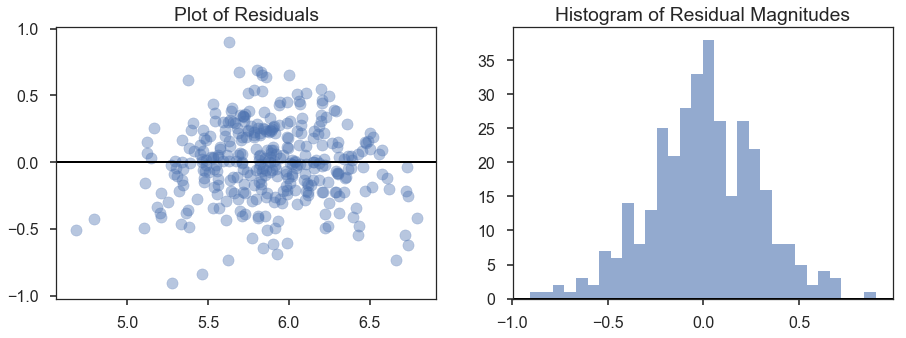

In [76]:
#check residuals
y_pred = linear_model.predict(x)
#Residuals
res = y - y_pred

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_pred, res, alpha=.4)#y_pred - y_train[:,0])
axes[0].axhline(0, c='black', lw=2)

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(res, bins=30, alpha=0.6)
axes[1].axhline(0, c='black', lw=2)
plt.show()


In [77]:
max_score = 0
max_k = 0 


for k in range(1,26):
    knn = KNN(n_neighbors = k)
    score = cross_val_score(knn,x,y).mean()
    if score > max_score:
        max_k = k
        max_score = score
 

knn = KNN(n_neighbors = max_k)
knn.fit(x, y)

print('KNN R^2 in Test:', '(Optimal K is ' + str(max_k) +')',  knn.score(X_test,y_test))

KNN R^2 in Test: (Optimal K is 10) 0.520329512483


linear, ridge, and lasso appear to perform equally well in test set, which makes sense given we've already performed variables selection using forward stepwise regression before running these models

#### Pre-selected variables

In [78]:
x3 = train1.loc[:, train1.columns.isin(['Burglary', 
       'Larceny-theft', 'Motor vehicle theft',  'Property Crime',
        'Year','Male_Median_Age',
       'Sex_ratio(males per 100 females)', '%White alone',
       'Now_married', 'Unemployment rate', 'Below_poverty_level', 
       'HS_Grad_or_Higher', 'PopSize', 'Region_East South Central', 'Region_Middle Atlantic',
       'Region_Mountain', 'Region_New England', 'Region_Pacific',
       'Region_South Atlantic', 'Region_West North Central',
       'Region_West South Central','% 1-person households',
       'Ratio less than 10k to 65K+ income', 'Ratio Owned to Rented homes'])]  

X_test3 = test1.loc[:, test1.columns.isin(['Burglary', 
       'Larceny-theft', 'Motor vehicle theft',  'Property Crime',
        'Year', 'Male_Median_Age',
       'Sex_ratio(males per 100 females)', '%White alone',
       'Now_married', 'Unemployment rate', 'Below_poverty_level', 
       'HS_Grad_or_Higher', 'PopSize', 'Region_East South Central', 'Region_Middle Atlantic',
       'Region_Mountain', 'Region_New England', 'Region_Pacific',
       'Region_South Atlantic', 'Region_West North Central',
       'Region_West South Central','% 1-person households',
       'Ratio less than 10k to 65K+ income', 'Ratio Owned to Rented homes'])]  

In [79]:
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
lassoCV_model = LassoCV(n_alphas = 100)
lassoCV_model.fit(x3, y)

RidgeCV_model = RidgeCV(alphas=(.1,1.0,10.0,100.0,1000.0,10000.0))
RidgeCV_model.fit(x3, y)

linear_model = LinearRegression()
linear_model.fit(x3, y)
print('R^2 in Train:', '\nLinear:',linear_model.score(x3, y),
      ' Lasso:',lassoCV_model.score(x3, y), ' Ridge:',RidgeCV_model.score(x3,y))
print('R^2 in Test:','\nLinear:',linear_model.score(X_test3,y_test),
      ' Lasso:',lassoCV_model.score(X_test3,y_test),' Ridge:', RidgeCV_model.score(X_test3, y_test))


R^2 in Train: 
Linear: 0.62552907762  Lasso: 0.613590135711  Ridge: 0.616964167081
R^2 in Test: 
Linear: 0.586051573744  Lasso: 0.620767100451  Ridge: 0.620119587281


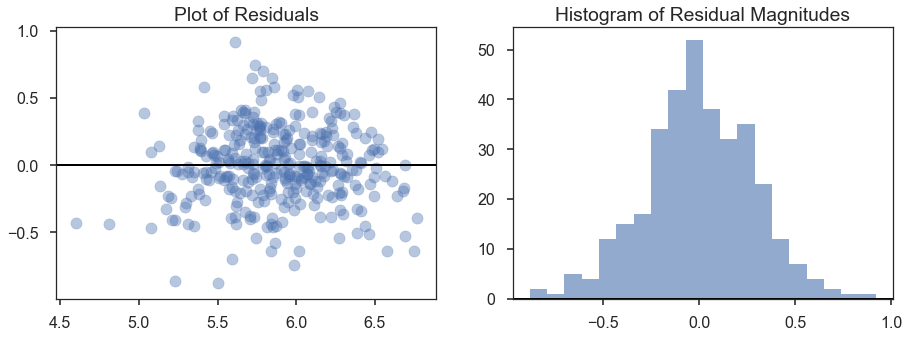

In [80]:
#check residuals
y_pred = linear_model.predict(x3)
#Residuals
res = y - y_pred

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_pred, res, alpha=.4)#y_pred - y_train[:,0])
axes[0].axhline(0, c='black', lw=2)

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(res, bins=20, alpha=0.6)
axes[1].axhline(0, c='black', lw=2)
plt.show()


In [81]:
max_score = 0
max_k = 0 


for k in range(1,26):
    knn = KNN(n_neighbors = k)
    score = cross_val_score(knn,x3,y).mean()
    if score > max_score:
        max_k = k
        max_score = score
 

knn = KNN(n_neighbors = max_k)
knn.fit(x3, y)

print('KNN R^2 in Test:', '(Optimal K is ' + str(max_k) +')',  knn.score(X_test3, y_test))

KNN R^2 in Test: (Optimal K is 9) 0.54676843404


In [82]:
x_train3 = add_constant(x3)
multi_regression_model3 = sm.OLS(y, x_train3).fit()
print(multi_regression_model3.summary())

                            OLS Regression Results                            
Dep. Variable:      log_Violent_Crime   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     21.85
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           3.43e-53
Time:                        20:08:57   Log-Likelihood:                -51.291
No. Observations:                 339   AIC:                             152.6
Df Residuals:                     314   BIC:                             248.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

selecting Lasso Regression model using pre-selected variables as final model:

In [83]:
print('Final Model Intercept + Coefficients:\n',lassoCV_model.intercept_,  lassoCV_model.coef_)
# Lasso set larceny theft, year, male median age, ratio owned to rented homes, 
# Region: East South Central, Region: Mid-Atlantic, Region: Mountain, Region: New England to zero

Final Model Intercept + Coefficients:
 5.86553219489 [ 0.1261722   0.          0.09177023  0.03568017 -0.          0.
 -0.01095781 -0.06326644 -0.03146981  0.08726055 -0.13385056  0.
  0.05606813  0.031637   -0.07390454  0.00097755  0.         -0.         -0.
 -0.         -0.17747683  0.01422473  0.17449511  0.14056061]
